# Simulation of Planet Earth from Geostationary Orbit

In [1]:
%load_ext eradiate.notebook

import eradiate
import matplotlib.pyplot as plt
import numpy as np
from eradiate import scenes as ertsc
from eradiate import unit_registry as ureg
import xarray as xr
import mitsuba as mi

eradiate.set_mode("ckd_polarized")

### HAMSTER dataset (global hyperspectral albedo maps)

The HAMSTER dataset by G. Roccetti et. al is available from https://opendata.physik.lmu.de/04zd8-7et52/. In order to run this notebook you need to download one of the files for a particular date.  

The dataset contains 365 hyperspectral albedo maps of Earth, one for each day of the year. The hyperspectral albedo maps are built from a 10-year average of the MODIS Surface Reflectance dataset (MCD43D 42-48, version 6.1). Using a Principal Component Analysis (PCA) regression algorithm different hyperspectral laboratory and in-situ measurements spectra of various dry soils, vegetation surfaces and mixure of both were combined to reconstruct the albedo maps in the entire wavelength range from 400 to 2500 nm, with a spectral resolution of 10 nm. The hyperspectral albedo maps have a spatial resolution of 0.05° in latitude and longitude. Additional hyperspectral albedo maps with a coarser spatial or spectral resolution are available upon request. 

For details please refer to the publication: 

HAMSTER: Hyperspectral Albedo Maps dataset with high Spatial and TEmporal Resolution, Roccetti et al., 2024, https://doi.org/10.5194/egusphere-2024-167.



In [2]:
# Load the NetCDF file
doy = "160"  # summer 001 winter
ds = xr.open_dataset(f"DOY{doy}.nc")

# Display the dataset
ds

<xarray.Dataset> Size: 22GB
Dimensions:           (lon: 7200, lat: 3600, wvl: 211)
Dimensions without coordinates: lon, lat, wvl
Data variables:
    Longitude         (lon) float32 29kB ...
    Latitude          (lat) float32 14kB ...
    Wavelength        (wvl) float32 844B ...
    Black_Sky_Albedo  (lat, lon, wvl) float32 22GB ...
Attributes:
    description:  HAMSTER: Hyperspectral Albedo Maps dataset with high Spatia...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9999.0..0.9944153].


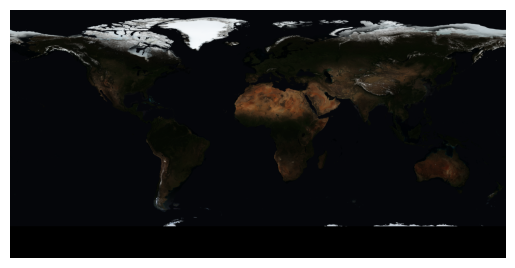

In [3]:
# Extract relevant data variables
albedo = ds["Black_Sky_Albedo"]
wavelengths = ds["Wavelength"]
# Define target wavelengths to be used to generte a RGB image
w = [640, 550, 470]
# Find the nearest indices for those wavelengths
nearest_indices = [int(np.abs(wavelengths - wvl).argmin()) for wvl in w]
# Extract albedo at those wavelengths
selected_albedo = albedo.isel(wvl=nearest_indices)
# Convert to a NumPy array
# Resulting shape: (lat, lon, 3)
albedo_array = selected_albedo.values

plt.imshow(albedo_array, vmin=0, vmax=1)
plt.axis("off");

Shift the data, so that 0° longitude is on the left of the image. This way, the position vector [0,0,z] is at [0°lat, 0°lon]. We will later define the position of the sensor.

In [4]:
albedo_shifted = np.roll(albedo_array, albedo_array.shape[1] // 2, axis=1)
albedo_array = albedo_shifted
albedo_array[albedo_array == -9999] = 0

Now we save the data in EXR format which is compatible to Mitsuba.

In [5]:
# Ensure array is contiguous
albedo_array = np.ascontiguousarray(albedo_array)

# So far there is no 'rgb' mode in Eradiate, therefore we need to store a file for each wavelength
for i in range(3):
    # Save as EXR using Mitsuba Bitmap
    bitmap = mi.Bitmap(albedo_array[:, :, i], pixel_format=mi.Bitmap.PixelFormat.Y)

    bitmap.write(f"earth_albedo_{i}.exr")

# This works if we use the Mitsuba renderer without Eradiate and 'RGB' mode
# bitmap = mi.Bitmap(
#     albedo_array,
#     pixel_format=mi.Bitmap.PixelFormat.RGB
# )

# bitmap.write(f"earth_albedo.exr")

### Generate ocean-land mask

We want to simulate the land surface using the Lambertian reflector model and the ocean surface as a bidirectional reflectance distribution function (BSDF) taking into account the specular reflection of water surfaces causing the sun glint. 

Looking at the HAMSTER data, we find that the ocean always has exactly the same values and we use these to define the mask. Some data are missing at the poles where MODIS does not provide observations (North pole in winter and South pole in summer). We set these values to 0.0, for our simulation we assign ocean to these regions. 

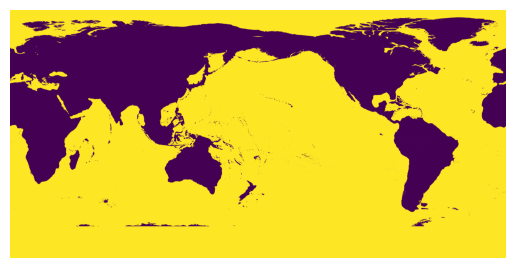

In [6]:
# Wavelength-specific invalid values for [640, 550, 470 nm]
invalid_per_band = np.array([0.02091217, 0.02664185, 0.04164886])

# Start by masking 0
mask_invalid = albedo_array == 0

# Then also mask wavelength-specific invalid values
for i in range(3):
    mask_invalid[..., i] |= albedo_array[..., i] == invalid_per_band[i]

# Collapse to 2D mask (True where any band is invalid)
ocean_mask = mask_invalid.any(axis=2).astype(np.float32)

plt.imshow(ocean_mask[:, :])
plt.axis("off");

Now we see that (lat,lon)=(0°,0°) is on the left of the map. Land is shown in blue and ocean in yellow.

In [7]:
# Save the mask as EXR using Mitsuba Bitmap
ocean_bitmap = mi.Bitmap(ocean_mask, pixel_format=mi.Bitmap.PixelFormat.Y)
ocean_bitmap.write("earth_ocean_mask.exr")

### Setup the model atmosphere 

In [8]:
atmosphere = ertsc.atmosphere.MolecularAtmosphere(
    thermoprops={
        "identifier": "afgl_1986-us_standard",
        "z": np.linspace(0.0, 120.0, 121) * ureg.km,
    },
)
geometry = ertsc.geometry.SphericalShellGeometry(
    toa_altitude=120.0 * ureg.km,
    ground_altitude=0.0 * ureg.km,
    zgrid=np.linspace(0.0, 120.0, 121) * ureg.km,
    planet_radius=eradiate.constants.EARTH_RADIUS,
)

### Define an eradiate experiment to generate an image of a geostationary satellite (like e.g. Meteosat Third Generation)

In [9]:
def run_exp(
    w, i_w, spp, Npixel, sza, saa, target, geometry, atmosphere, integrator=None
):
    """
    Run a global Eradiate simulation.

    Parameters
    ----------
    w : float or array-like
        Wavelength(s) for the simulation.
    i_w : int
        Index or identifier for the current wavelength.
    spp : int
        Samples per pixel.
    Npixel : int
        Number of pixels in the simulation.
    sza : float
        Solar zenith angle (degrees).
    saa : float
        Solar azimuth angle (degrees).
    target : str or object
        Target surface or model to simulate.
    geometry : dict or object
        Scene geometry configuration.
    atmosphere : dict or object
        Atmospheric configuration.
    integrator : object, optional
        Integrator to use for the simulation (default: None).

    Returns
    -------
    result : dict or object
        Simulation result from Eradiate.
    """

    if integrator is None:
        integrator = ertsc.integrators.VolPathIntegrator()

    exp = eradiate.experiments.AtmosphereExperiment(
        # Include the geometry and the atmosphere defined above
        geometry=geometry,
        atmosphere=atmosphere,
        # The surface would be a 1D surface, we set it to None and include the global map instead.
        surface=None,
        # The kdict option allows to include any objects that are available in Mitsuba.
        # We use it to include the global surface albedo map
        kdict={
            "earth": {
                "id": "earth",
                "type": "sphere",  # Define a sphere with the Earth radius
                "radius": 6371000,  # eradiate.constants.EARTH_RADIUS.to("m"),  # In Mitsuba we need to define all lengths in m
                # Define the surface properties as a "blendbsdf", which allows to mix different surface types
                "bsdf": {
                    "type": "blendbsdf",
                    # The first surface type is for land and we include the HAMSTER surface albedo map
                    "bsdf_1": {
                        "type": "diffuse",
                        "reflectance": {
                            "type": "bitmap",
                            "filename": f"earth_albedo_{i_w}.exr",
                            "wrap_mode": "repeat",
                        },
                    },
                    # The second includes the ocean reflectance matrix as defiend by Mishchenko (1999)
                    "bsdf_2": {
                        "type": "ocean_mishchenko",
                        "wind_speed": 5,  # wind speed above ocean surface, here assumed constant
                        "eta": 1.33,  # refractive index of water
                    },
                    "weight": {
                        "type": "bitmap",
                        "filename": "earth_ocean_mask.exr",  # Use ocean mask as blend weight
                        "wrap_mode": "repeat",
                    },
                },
                "to_world": mi.ScalarTransform4f.rotate(
                    [0, 0, 1], -90
                ),  # Align poles: Z-up
            }
        },
        # Define the light source (sun position), irradiance is set to 1.0, this means we will get normalied reflectances.
        illumination={
            "type": "directional",
            "zenith": sza,
            "azimuth": saa,
            "irradiance": 1.0,
        },
        # Define the sensor as a "PerspectiveCamera"
        measures=[
            eradiate.scenes.measure.PerspectiveCameraMeasure(
                id="radiances",
                # Location of sensor in geostationary orbit at 36.000km from Earth surface
                origin=[
                    0,
                    -(eradiate.constants.EARTH_RADIUS.to("m").magnitude + 36.0e6),
                    0,
                ],
                # A field of view of 18° includes the complete globe
                fov=18,
                # Spectral response function - delta function for simplicity
                srf={"type": "multi_delta", "wavelengths": w},
                # Number of samples
                spp=spp,
                # Target where the camera points to (vector)
                target=target,
                # Orientation of the image
                up=[0, 0, 1],
                # needs to be larger than sensor position
                far_clip=1e15,
                # resultion of the image
                film_resolution=(Npixel, Npixel),
            ),
        ],
        integrator=integrator,
    )

    exp.integrator.stokes = True
    exp.integrator.meridian_align = True

    return eradiate.run(exp, spp=spp)

### Define general settings for the Eradiate simulation and run simulation

In [10]:
id_simulation = "geostationary_image_summer"

# number of samples
N = 100
# number of pixels (x and y) of the perspective camera
Npixel = 150

# Sun position
sza = 70
saa = 220

# Target where the camera points at
target = np.array([0, 0, 0])

# Initialize an array to store the results for the 3 wavelengths, 4 corresponds to Stokes vector components
radiance = np.zeros((len(w), 4, Npixel, Npixel))  # numpy array to save results

# Run simulations for 3 wavelengths
for i_w in range(3):
    result_eradiate = run_exp(
        w=w[i_w],
        i_w=i_w,
        spp=N,
        Npixel=Npixel,
        sza=sza,
        saa=saa,
        target=target,
        geometry=geometry,
        atmosphere=atmosphere,
    )

    for j in range(4):
        radiance[i_w, j, :, :] = result_eradiate.radiance.data[0, j, :, :, 0, 0]

# save the result as a numpy array
np.save(f"radiance_{id_simulation}.npy", radiance)

0/16|          | 00:00, ETA=?

0/16|          | 00:00, ETA=?

0/16|          | 00:00, ETA=?

### Plot the RGB image

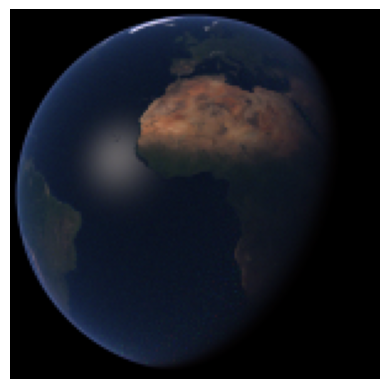

In [11]:
image = np.zeros((Npixel, Npixel, 3))

image[:, :, 0] = radiance[0, 0, :, :]
image[:, :, 1] = radiance[1, 0, :, :]
image[:, :, 2] = radiance[2, 0, :, :]

image /= image.max()

plt.imshow(image ** (1.0 / 1.2), alpha=1.0)
plt.axis("off")

plt.imsave(f"image_{id_simulation}.png", image)

### Plot Stokes vector and degree of polarization

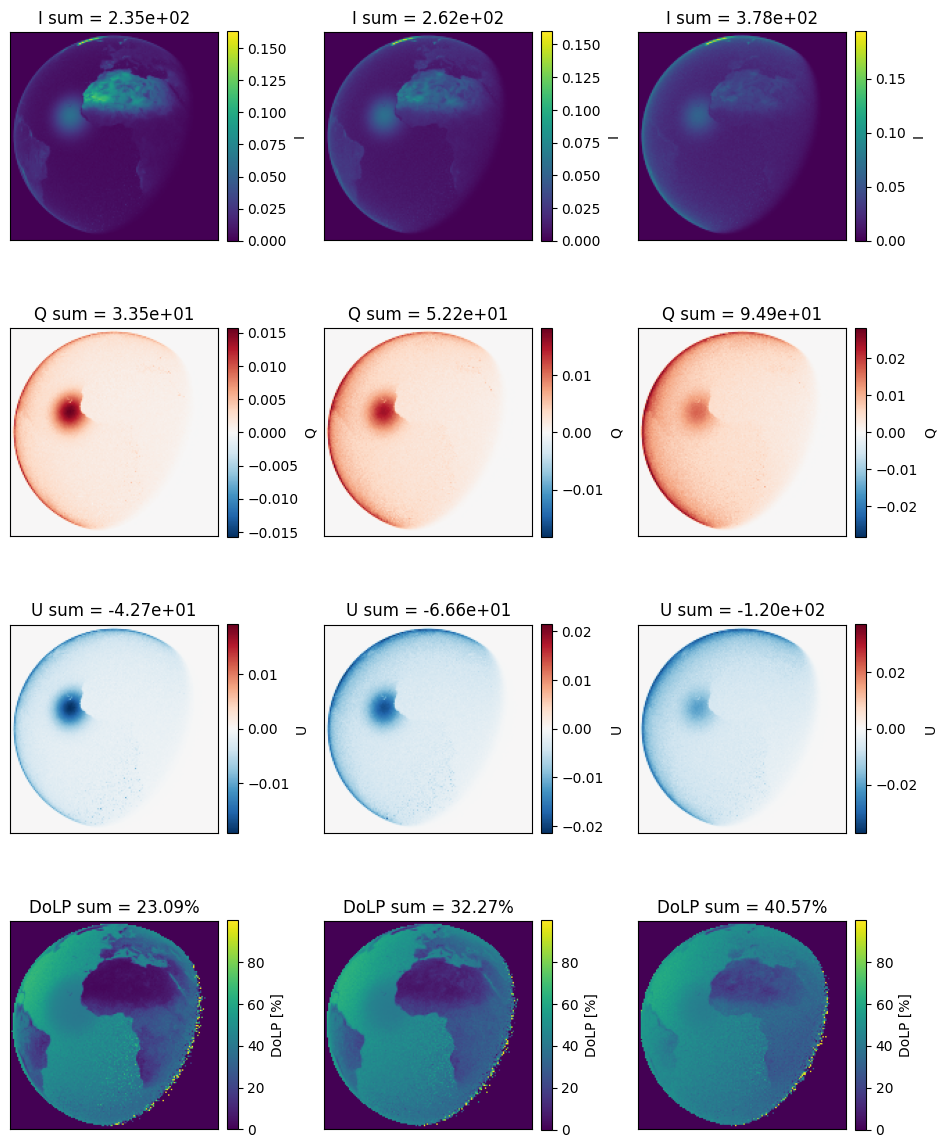

In [12]:
plt.figure(1, figsize=(12, 12))

for i_pa in range(len(w)):
    I = radiance[i_pa, 0, :, :]
    Q = radiance[i_pa, 1, :, :]
    U = radiance[i_pa, 2, :, :]

    sum_I = np.sum(I)
    sum_Q = np.sum(Q)
    sum_U = np.sum(U)

    dop_sum = np.sqrt(sum_Q**2 + sum_U**2) / np.maximum(sum_I, 1e-10) * 100.0

    # --- I component ---
    ax1 = plt.subplot(4, 4, i_pa + 1)
    im1 = ax1.imshow(I)  # transpose!
    ax1.set_xticks([])
    ax1.set_yticks([])
    cbar = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label("I")
    ax1.set_title(f"I sum = {sum_I:.2e}")

    # --- Q component (diverging colormap) ---
    ax2 = plt.subplot(4, 4, i_pa + 5)
    im2 = ax2.imshow(
        Q,  # transpose!
        cmap="RdBu_r",
        vmin=-np.max(np.abs(Q)),
        vmax=+np.max(np.abs(Q)),
    )
    ax2.set_xticks([])
    ax2.set_yticks([])
    cbar = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    cbar.set_label("Q")
    ax2.set_title(f"Q sum = {sum_Q:.2e}")

    # --- U component (also diverging colormap) ---
    ax3 = plt.subplot(4, 4, i_pa + 9)
    im3 = ax3.imshow(
        U,  # transpose!
        cmap="RdBu_r",
        vmin=-np.max(np.abs(U)),
        vmax=+np.max(np.abs(U)),
    )
    ax3.set_xticks([])
    ax3.set_yticks([])
    cbar = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
    cbar.set_label("U")
    ax3.set_title(f"U sum = {sum_U:.2e}")

    # --- DoP ---
    ax4 = plt.subplot(4, 4, i_pa + 13)
    dop = np.sqrt(Q**2 + U**2) / np.maximum(I, 1e-10) * 100.0
    dop = np.clip(dop, 0, 100)

    im4 = ax4.imshow(dop)  # transpose!
    ax4.set_xticks([])
    ax4.set_yticks([])
    cbar = plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
    cbar.set_label("DoLP [%]")
    ax4.set_title(f"DoLP sum = {dop_sum:.2f}%")

plt.tight_layout()
# plt.savefig(f'polarization_{id_simulation}.png')
plt.show()